In [2]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_loading_rt import RTDataset
from unet.unet_model_rt import UNet
from utils.utils import plot_img_and_mask

import random

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split

from scipy import ndimage, datasets

dir_checkpoint = Path('./checkpoints/')

building_height_map_dir = os.path.abspath('/dev/shm/res_plane/Bl_building_npy')
terrain_height_map_dir = os.path.abspath('/dev/shm/res_plane/Bl_terrain_npy')
ground_truth_signal_strength_map_dir = os.path.abspath('/dev/shm/coverage_maps_data_aug_Jul18/')
sparse_ss_dir = Path('/home/yl826/3DPathLoss/nc_raytracing/jul18_sparse')




In [3]:
# 1. Create dataset

dataset = RTDataset(building_height_map_dir, terrain_height_map_dir,ground_truth_signal_strength_map_dir,sparse_ss_dir, 0.5, True)
    

    


# 2. Split into train / validation partitions


# n_val = int(len(dataset) * val_percent)
# n_train = len(dataset) - n_val
# train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

# This is a custom implementation of random split in order to avoid the data leak when using 
# our data augmentation 
ids = dataset.get_ids()
print("# of Total Ids: ",len(ids))
file_id_set = set([ int(ids_file_name.split("_")[0]) for ids_file_name in ids])
print("# of Total Ori Index: ",len(file_id_set))
train_set_ori_idx, val_set_ori_idx = train_test_split(list(file_id_set), test_size=0.2, random_state=42)

print("# of Train Ori Index: ",len(train_set_ori_idx))
print("# of Val Ori Index: ",len(val_set_ori_idx))

train_set_idx = []
val_set_idx = []
for cur_idx, cur_ids in enumerate(ids):
    if int(cur_ids.split("_")[0]) in train_set_ori_idx:
        train_set_idx.append(cur_idx)
    else:
        val_set_idx.append(cur_idx)

n_train = len(train_set_idx)
n_val = len(val_set_idx)
# print("# of Train Index: ",len(train_set_idx))
# print("# of Val Index: ",len(val_set_idx))

#Do a sanity check
tmp_train_idx_set = set([ int(ids[tmp_idx].split("_")[0]) for tmp_idx in train_set_idx])
tmp_val_idx_set = set([ int(ids[tmp_idx].split("_")[0]) for tmp_idx in val_set_idx])
#print(tmp_val_idx_set)
#print("Check this",set(tmp_val_idx_set).intersection(tmp_train_idx_set))

train_set = torch.utils.data.Subset(dataset, train_set_idx)
val_set = torch.utils.data.Subset(dataset, val_set_idx)


# 3. Create data loaders
loader_args = dict(batch_size=1, num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(train_set, shuffle=True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|███| 96465/96465 [00:23<00:00, 4053.66it/s]


# of Total Ids:  96365
# of Total Ori Index:  6431
# of Train Ori Index:  5144
# of Val Ori Index:  1287


torch.Size([1, 3, 100, 100])
(100, 100)


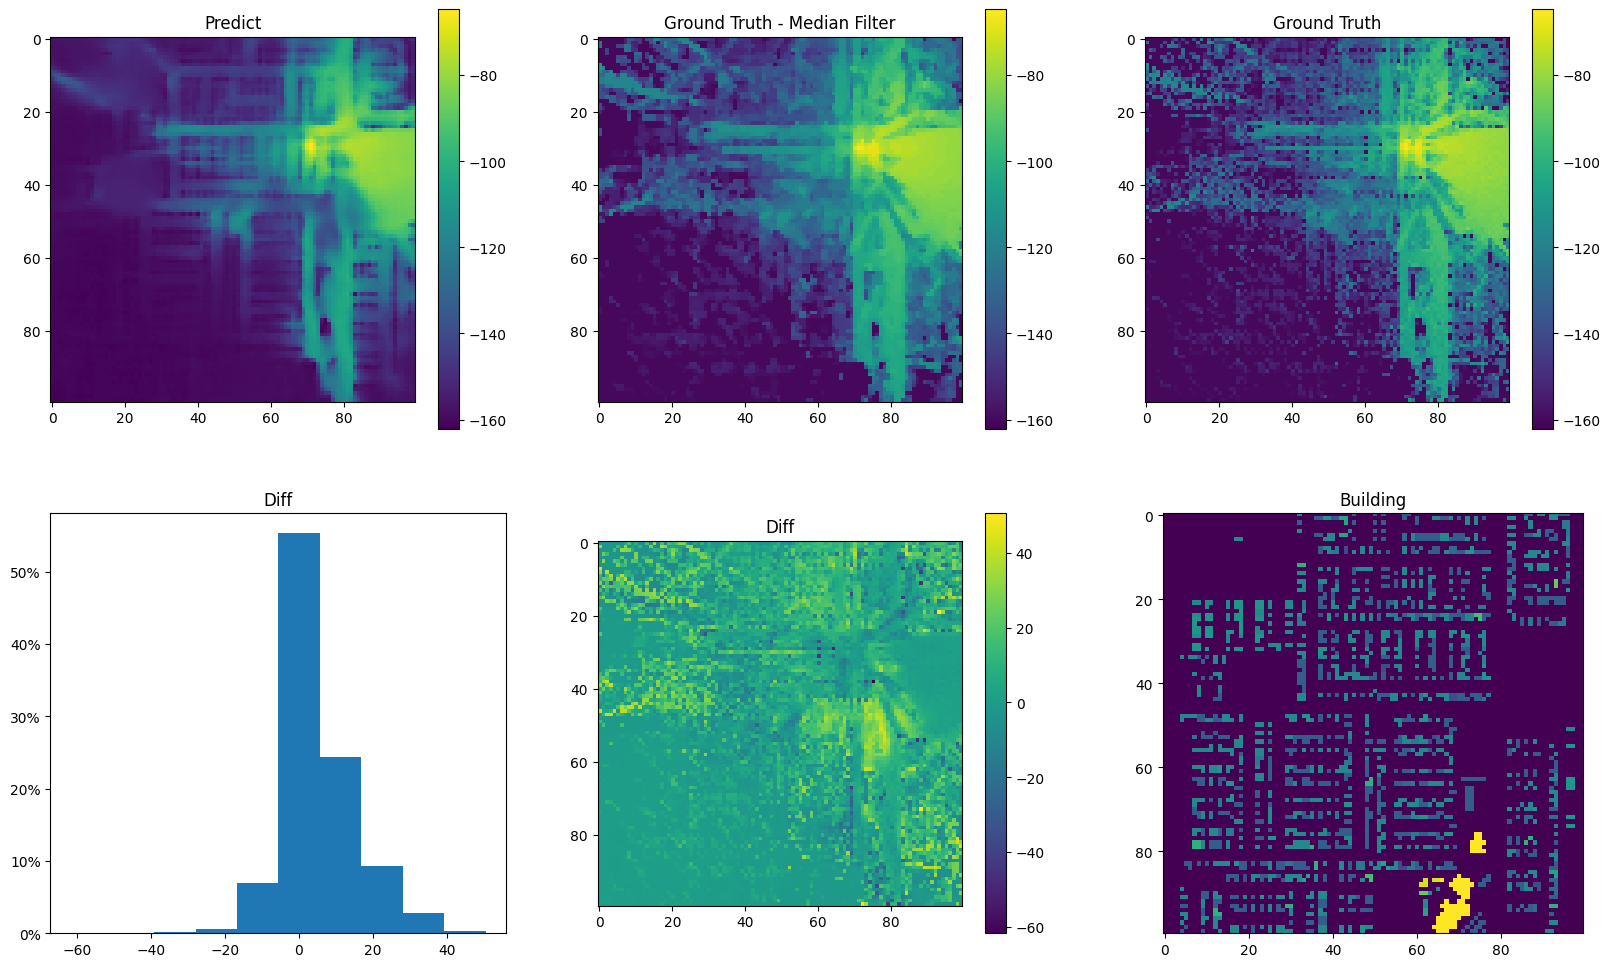

In [15]:
import matplotlib.ticker as mtick


net = UNet(n_channels=2, n_classes=1, bilinear=False, pathloss=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net.to(device=device)

state_dict = torch.load("checkpoints/checkpoint_epoch200.pth", map_location=device)
net.load_state_dict(state_dict)

logging.info('Model loaded!')

for batch in train_loader:
    images, ground_truth = batch['combined_input'], batch['ground_truth']
    sparse_ss = batch['sparse_ss']
    net.eval()
    print(images.shape)
    images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
    ground_truth = ground_truth.to(device=device, dtype=torch.long)
    sparse_ss = sparse_ss.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(images, sparse_ss).cpu()

    output = output.squeeze().cpu().numpy()
    print(output.shape)

    import torch.nn as nn



    # Create a figure with two subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    

    
    
    
    vmin = min([np.min(output),np.min(ground_truth[0].cpu().numpy())])
    vmax = max([np.max(output),np.max(ground_truth[0].cpu().numpy())])
    # Plot the first image in the left subplot
    im = axes[0,0].imshow(output,vmin=vmin,vmax=vmax)
    axes[0,0].set_title('Predict')
    fig.colorbar(im)

    # Plot the second image in the right subplot
    im = axes[0,1].imshow(ndimage.median_filter(ground_truth[0].cpu(), size=2),vmin=vmin,vmax=vmax)
    axes[0,1].set_title('Ground Truth - Median Filter')
    fig.colorbar(im)
    
    
    
        # Plot the second image in the right subplot
    im = axes[0,2].imshow(ground_truth[0].cpu(),vmin=vmin,vmax=vmax)
    axes[0,2].set_title('Ground Truth')
    fig.colorbar(im)
    
    
    
    im = axes[1,1].imshow((ground_truth[0].cpu() - output))
    axes[1,1].set_title('Diff')
    fig.colorbar(im)
    
    data = (ground_truth[0].cpu() - output).flatten()
    im = axes[1,0].hist(data, weights=np.ones(len(data)) / len(data))
    axes[1,0,].yaxis.set_major_formatter(mtick.PercentFormatter(1))
    axes[1,0].set_title('Diff')
    
    
    axes[1,2].imshow(images[0,0,:,:].cpu())
    axes[1,2].set_title('Building')
    
    
    
    np.abs(ground_truth[0].cpu() - output)

    # Set spacing between subplots
    #plt.subplots_adjust(wspace=0.4)

    # Display the figure
    plt.show()
    criterion = nn.MSELoss()

    break

    loss = criterion(torch.from_numpy(output), torch.from_numpy(ground_truth))
    print("Loss: %f"%loss)


    # if not args.no_save:
    #     out_filename = out_files[i]
    #     result = mask_to_image(mask, mask_values)
    #     result.save(out_filename)
    #     logging.info(f'Mask saved to {out_filename}')
    #
    # if args.viz:
    #     logging.info(f'Visualizing results for image {filename}, close to continue...')
    #     plot_img_and_mask(img, mask)

In [5]:
import torch.nn as nn

downSampling = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=10, stride=10, padding=0)
arr = np.load(os.path.join(building_height_map_dir,filename))[40:1040,40:1040]
combined_input = np.zeros((1, arr.shape[0], arr.shape[1]))
combined_input[0,:,:] = arr

combined_input = np.float32(combined_input)
print(combined_input.dtype)
trorchres = torch.as_tensor(combined_input)
res = downSampling(trorchres)
print("torch min:",np.min(trorchres.detach().numpy()))
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2)

# Plot the first image in the left subplot
axes[0].imshow(arr)
axes[0].set_title('Predict')

# Plot the second image in the right subplot
axes[1].imshow(res[0].detach().numpy())
axes[1].set_title('Ground Truth')

# Set spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the figure
plt.show()
criterion = nn.MSELoss()

loss = criterion(torch.from_numpy(output), torch.from_numpy(ground_truth))
print("Loss: %f"%loss)


import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(np.max(res[0].detach().numpy()))
print(np.max(arr))
print(res[0].detach().numpy())

smaller_img = arr[::10, ::10]
plt.imshow(smaller_img)

NameError: name 'filename' is not defined

In [ ]:
import cv2
import numpy as np


smaller_opcv = cv2.resize(arr, dsize=(100, 100),interpolation=cv2.INTER_NEAREST)
plt.imshow(smaller_opcv)


In [ ]:
import argparse
import logging
import os

import numpy as np

from PIL import Image



from utils.utils import plot_img_and_mask

import matplotlib.pyplot as plt

building_height_map_dir = os.path.abspath('../res_plane/Bl_building_npy')
terrain_height_map_dir = os.path.abspath('../res_plane/Bl_terrain_npy')
ground_truth_signal_strength_map_dir = os.path.abspath('/dev/shm/coverage_maps_data_aug_Jul7')


import os

# Example usage
directory_path = '/path/to/directory'  # Replace with the actual directory path
files = os.listdir(ground_truth_signal_strength_map_dir)
#print(files)
in_files = []
for file_name in files:
    filename_only = file_name.split("_")[0] +"_"+ file_name.split("_")[1]
    in_files.append(filename_only+".npy")
    #print(in_files[-1])




for i, filename in enumerate(files):
    if not filename.endswith(".npy"):
        continue
    logging.info(f'Predicting image {filename} ...')

    building_filename = file_name.split("_")[0] +"_"+ file_name.split("_")[1]+".npy"
    building_img = np.load(os.path.join(building_height_map_dir,building_filename))[4:104,4:104]
    print(building_img.shape)
    #terrain_img = np.load(os.path.join(terrain_height_map_dir,filename))[4:104,4:104]
    # combined_input = np.zeros((1,2, building_img.shape[0], terrain_img.shape[1]))
    # combined_input[0,0,:, :] = building_img  # Assign first channel data
    # combined_input[0,1,:, :] = terrain_img  # Assign second channel data

    

  
    #img = img.unsqueeze(0)

    ground_truth = np.load(os.path.join(ground_truth_signal_strength_map_dir,filename))
    
    #print(ground_truth)

   

    #print(building_img.shape)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2)

    # Plot the first image in the left subplot
    axes[0].imshow(building_img)
    axes[0].set_title('Building')
    # Plot the second image in the right subplot
    axes[1].imshow(ground_truth)
    axes[1].set_title('Ground Truth')

    # Set spacing between subplots
    plt.subplots_adjust(wspace=0.4)
    fig.suptitle(filename) # or plt.suptitle('Main title')
    # Display the figure
    plt.show()
    if i > 100:
        break
    

    # if not args.no_save:
    #     out_filename = out_files[i]
    #     result = mask_to_image(mask, mask_values)
    #     result.save(out_filename)
    #     logging.info(f'Mask saved to {out_filename}')
    #
    # if args.viz:
    #     logging.info(f'Visualizing results for image {filename}, close to continue...')
    #     plot_img_and_mask(img, mask)


In [ ]:
# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    colab_compat = True # deactivate preview
except:
    colab_compat = False
resolution = [480,320] # increase for higher quality of renderings

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import os # Configure which GPU
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) # Avoid warnings from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.random.set_seed(1) # Set global random seed for reproducibility

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Paths2CIR

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

In [ ]:
# Load integrated scene
# scene = load_scene(os.path.join(os.path.abspath('../res/Bl_xml_files'),"5973_66affd6d-732f-4068-be2a-3ce5df70b4db/5973_66affd6d-732f-4068-be2a-3ce5df70b4db.xml")) # Try also sionna.rt.scene.etoile
scene = load_scene(os.path.join(os.path.abspath('../res_plane/Bl_xml_files'),"0_ca290c79-7674-471b-85df-d24c59f989e7/0_ca290c79-7674-471b-85df-d24c59f989e7.xml")) # Try also sionna.rt.scene.etoile
# Load integrated scene
#scene = load_scene(sionna.rt.scene.munich) # Try also sionna.rt.scene.etoile

In [2]:
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                          num_cols=1,
                          vertical_spacing=0.5,
                          horizontal_spacing=0.5,
                          pattern="tr38901",
                          polarization="VH")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                          num_cols=1,
                          vertical_spacing=0.5,
                          horizontal_spacing=0.5,
                          pattern="iso",
                          polarization="cross")

tx = Transmitter(name="tx",
                 position=[0,0,7+2+30], # top of Frauenkirche
                 orientation=[0,0,0])
scene.remove("tx")
scene.add(tx)
cm = scene.coverage_map(max_depth=8,
                        cm_cell_size=(10., 10.), # Grid size of coverage map cells in m
                        combining_vec=None,
                        precoding_vec=None,
                        num_samples=int(1e6),cm_center=[0,0,7+4],cm_orientation=[0,0,0],cm_size=[1000,1000])

NameError: name 'PlanarArray' is not defined

In [3]:
# Create new camera
tx_pos = scene.transmitters["tx"].position.numpy()

bird_pos = tx_pos.copy()
bird_pos[-1] = 1000 # Set height of coverage map to 1000m above tx
bird_pos[-2]-= 0.01 # Slightly move the camera for correct orientation

# Create new camera
bird_cam = Camera("birds_view", position=bird_pos, look_at=tx_pos)
scene.remove("birds_view")
scene.add(bird_cam)

if colab_compat:
    scene.render(camera="birds_view", coverage_map=cm, num_samples=512, resolution=resolution);
    raise ExitCell
# Open 3D preview (only works in Jupyter notebook)
scene.preview(coverage_map=cm)

NameError: name 'scene' is not defined

In [4]:
cm_tensor = cm.as_tensor()
cm_2D = cm_tensor.numpy()[0, :, :]

# saving as dB and tiff
# cm_2D[cm_2D == 0] = np.nan
cm_2D_dB = 10*np.log10(cm_2D)
# cm_img = Image.fromarray(cm_2D_dB)
# cm_img.save(img_path)

# saving as power and npy
plt.imshow(np.flip(cm_2D_dB,0))
# plt.imshow(cm_2D_dB)

NameError: name 'cm' is not defined